# 자동차 연비 예측하기: 회귀

### 텐서플로와 다른 라이브러리 임포트

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!conda list|grep seaborn

seaborn                   0.10.0                     py_0  


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [82]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

### Auto MPG 데이터셋 로딩

In [83]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/ec2-user/.keras/datasets/auto-mpg.data'

In [84]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 전처리

#### Q. 누락데이터 확인해서 제거하시오. (Hint : 누락 데이터 확인은 dataset.isna()으로 확인)

In [85]:
# 누락 데이터 확인은 dataset.isna()로 확인
#your code
dataset.isna().sum()
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

#### Origin을 이용해서 One-Hot Vector 형태의 세개의 컬럼을 생성 ( 1은 USA, 2는 Europe, 3은 Japan)

In [86]:
#origin = dataset.pop('Origin') # 1은 USA, 2는 Europe, 3은 Japan
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,1.0,0.0,0.0


#### Q. 데이터셋을 훈련 세트와 테스트 세트로 분할하시오. (Hint : dataset.sample(), dataset drop() 사용)

In [87]:
train_dataset = dataset.sample(frac = 0.8,random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

#### 산점도 행렬로 데이터 분포 및 상관성 조사

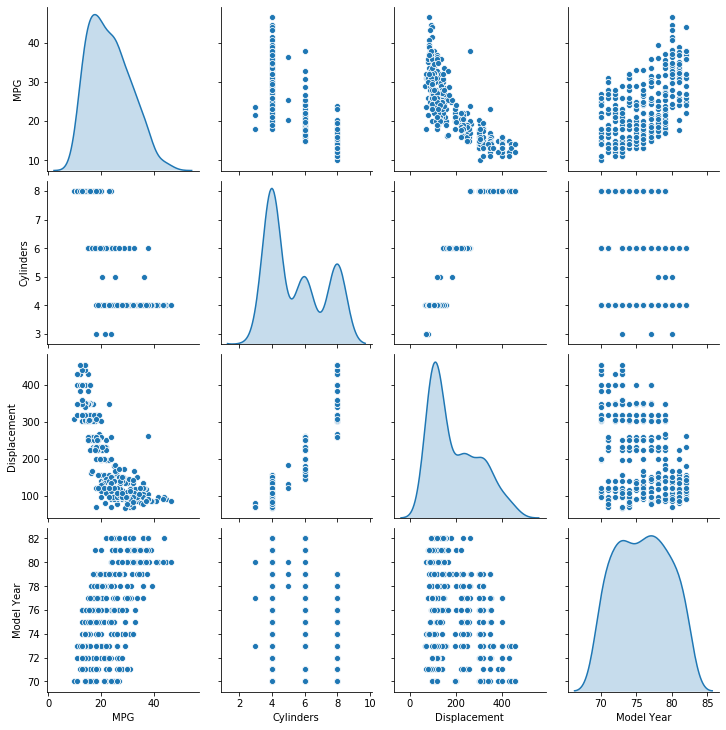

In [34]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Model Year"]], diag_kind="kde")

#### 통계 확인

In [88]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Q. 훈련 세트와 테스트 세트의 레이블 분리하시오. (Hint : dataset.pop() 사용)

In [89]:
# dataset.pop() 사용
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

####  데이터 정규화 
표준정규분포 정규화 사용 $z = \frac{X - \mu}{\sigma} \sim \mathcal{N}(0,1)$

In [90]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 모델

#### Q. 모델을 생성하는 build_model() 함수를 정의하시오.

In [91]:
def build_model():
  # input len(train_dataset.keys()) 
  # hidden 64, hidden 64, output 1
    model = keras.Sequential([
      keras.layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(1)
  ])
  # RMSProp으로 Optimizer 생성, learning rate = 0.001
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

  # loss, oprimizer, metric 설정
  # metric은 'mean_absolute_error’, 'mean_squared_error'로 설정
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error',
        'mean_squared_error'])
    return model

In [92]:
model = build_model()

In [93]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [94]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.33355987],
       [-0.03467418],
       [ 0.6274401 ],
       [ 0.19871782],
       [ 0.21271321],
       [ 0.00555858],
       [ 0.21993622],
       [ 0.2045042 ],
       [ 0.22386357],
       [ 0.3777869 ]], dtype=float32)

### 모델 훈련

#### Q. 모델을 훈련시키기 위해 model.fit() 함수를 완성하시오.
1. PrintDot() Callback 추가
2. validation_split을 이용해서 validation set은 training set의 20%로 설정
3. verbose=0로 설정해서 출력 없애기

In [95]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# 1. PrintDot() Callback 추가
# 2. validate_split을 이용해서 validation set은 training set의 20%로 설정
# 3. verbose=0로 설정해서 출력 없애기
history = model.fit(
    normed_train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,
callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 훈련 과정 시각화

In [96]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.486210,0.994782,2.486210,9.673951,2.330812,9.673950,995
996,2.493344,1.026710,2.493344,9.643673,2.338027,9.643673,996
997,2.365092,0.943385,2.365092,9.706305,2.327511,9.706305,997
998,2.549088,0.982828,2.549088,10.014517,2.364415,10.014518,998
999,2.493723,0.983999,2.493723,9.623518,2.342760,9.623518,999


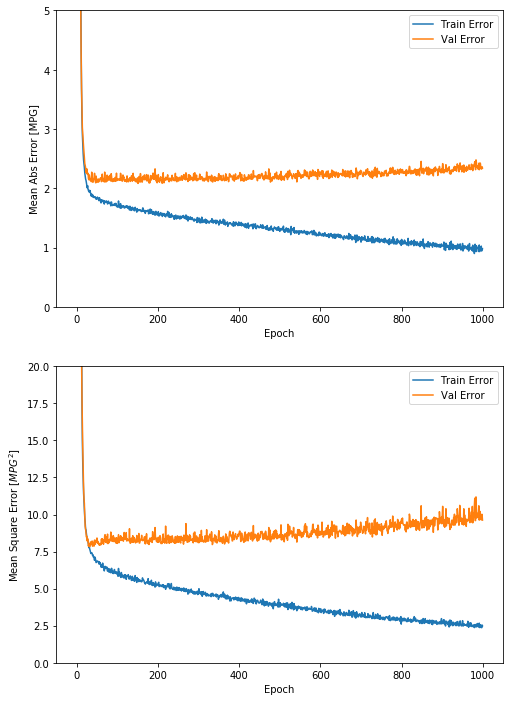

In [97]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
               label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
               label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

### EarlyStopping
https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping 참고
#### Q. 훈련 시 early stopping할 수 있도록 callback을 추가하시오.


....................................................................

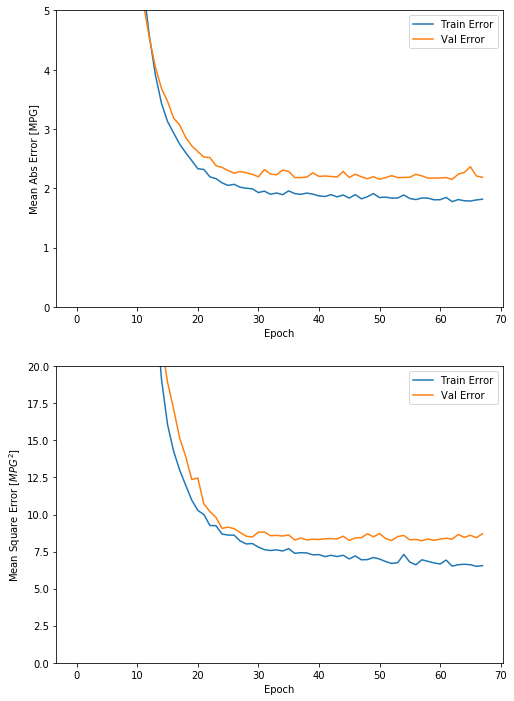

In [98]:
model = build_model()

# keras.callbacks.EarlyStopping 사용
# patience : 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [100]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

#print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.5328 - mean_absolute_error: 1.8535 - mean_squared_error: 5.5328


## 예측

#### 예측 테스트 결과와 실제 레이블과의 상관 관계 그래프

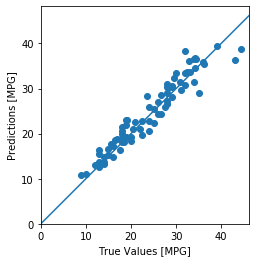

In [101]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#### 오차 분포 히스토그램

In [0]:
# 오차의 분포
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")